In [1]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# 이미지 전처리

In [2]:
import fingerprint as fp

In [3]:
img1 = cv2.imread('./train_ref/1.BMP',0)

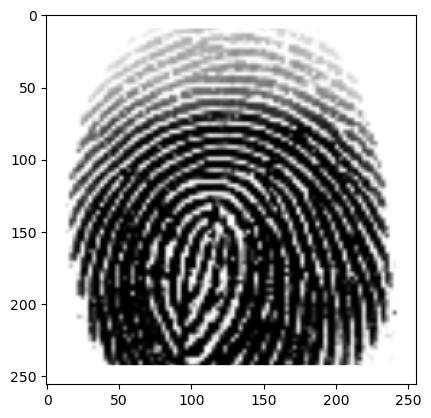

In [4]:
plt.imshow(img1, cmap='gray')

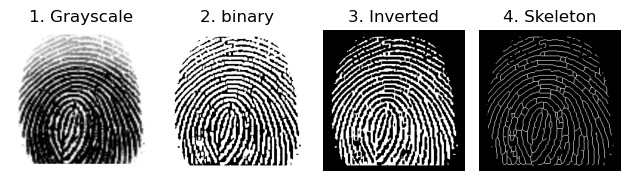

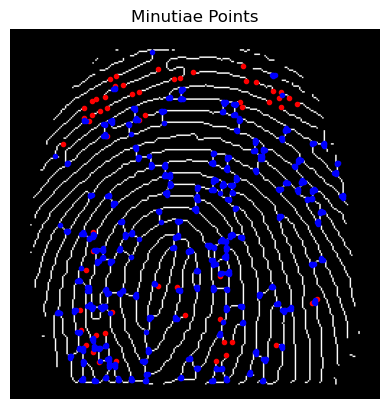

In [5]:
feat_end, feat_bif = fp.process_fingerprint_image(img1, visualize = True)

# Matching

In [6]:
train_path = './train_ref/'
test2_path = './test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))

In [7]:
target_path = list_test2[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
img_train = cv2.imread(train_sample_path)
img_test = cv2.imread(target_path)

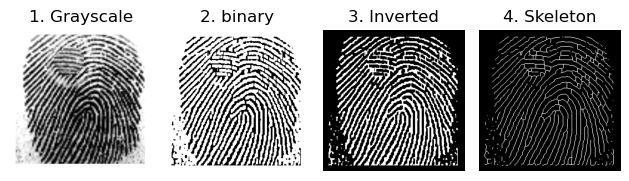

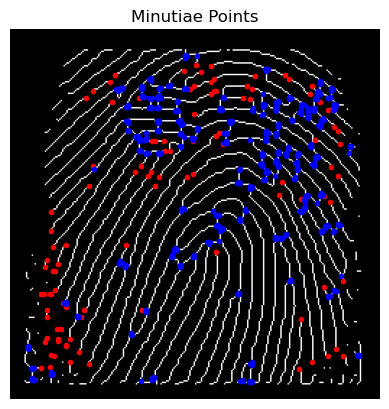

In [8]:
q_end, q_bif = fp.process_fingerprint_image(img_test, True)

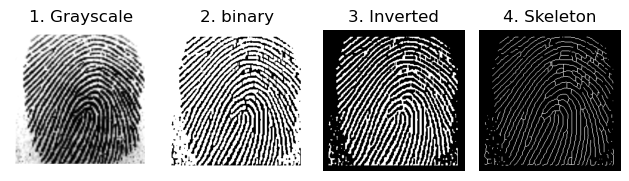

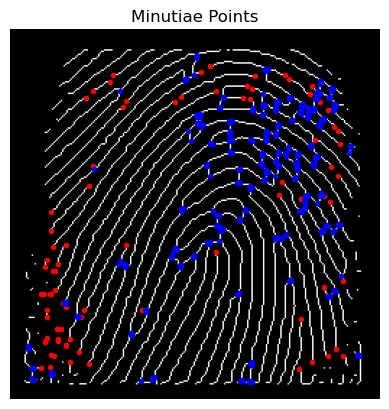

In [9]:
db_end, db_bif = fp.process_fingerprint_image(img_train, True)

In [10]:
feat_query = np.concatenate([q_end, q_bif]).astype(np.uint8)
feat_train = np.concatenate([db_end, db_bif]).astype(np.uint8)

In [11]:
print(len(feat_query), len(feat_train))

594 485


In [12]:
threshold = 50
score, match_num = fp.match_finger(feat_query, feat_train, threshold)
print(score, match_num)

25.0 449


In [13]:
def extract_label_from_filename(filename):
    # 파일 이름에서 숫자 부분 추출
    label_str = os.path.splitext(filename)[0]  # 파일 이름에서 확장자 제거
    label_str = ''.join(filter(str.isdigit, label_str))  # 숫자 부분 추출
    label = int(label_str)  # 정수로 변환
    return label

# 훈련 세트 생성
train_labels = [extract_label_from_filename(filename) for filename in list_train]
y_train = train_labels
x_train = []
for t in tqdm(list_train):
    basename = os.path.basename(t)
    img_train2 = cv2.imread(t)
    db_x_end, db_x_bif = fp.process_fingerprint_image(img_train2, False)
    feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
    x_train.append(feat_db_x)

# 테스트 세트 생성
test_labels = [extract_label_from_filename(os.path.basename(f).split('_')[0] + ".BMP") for f in list_test2]
y_test = test_labels
x_test = []
for t in tqdm(list_test2):
    basename = os.path.basename(t)
    img_test2 = cv2.imread(t)
    test_x_end, test_x_bif = fp.process_fingerprint_image(img_test2, False)
    feat_test_x = np.concatenate([test_x_end, test_x_bif]).astype(np.uint8)
    x_test.append(feat_test_x)

print("훈련 세트 크기:", len(x_train))
print("테스트 세트 크기:", len(x_test))

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

훈련 세트 크기: 477
테스트 세트 크기: 1428


In [16]:
# 매칭 결과 저장
y_pred = []

# 테스트 세트 각 이미지에 대해 매칭 계산
for test_x in tqdm(x_test):
    best_match_score = float('inf')
    best_index = 0
    index = 0

    # 훈련 세트 각 이미지에 대해 매칭 계산
    for train_x in x_train:
        # 매칭 계산
        match_score = fp.match_score(test_x, train_x, threshold)
        
        # 현재까지 가장 좋은 매칭보다 더 낮은 스코어라면 갱신
        if match_score < best_match_score:
            best_match_score = match_score
            best_index = index 
        index += 1
    # 매칭 결과 저장
    y_pred.append(y_train[best_index])

  0%|          | 0/1428 [00:00<?, ?it/s]

In [23]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

pred = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print("Precision: ", pred)
print("Recall: ", recall)

Precision:  0.9984276729559748
Recall:  0.9937106918238994


In [31]:
def calculate_far_frr(y_test, y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Initialize lists to store FAR and FRR for each class
    far_list = []
    frr_list = []
    
    # Number of classes
    num_classes = cm.shape[0]
    
    for i in range(num_classes):
        # Calculate False Positives (FP) for the current class
        FP = np.sum(cm[:, i]) - cm[i, i]
        
        # Calculate False Negatives (FN) for the current class
        FN = np.sum(cm[i, :]) - cm[i, i]
        
        # Calculate True Negatives (TN) for the current class
        TN = np.sum(cm) - (FP + FN + cm[i, i])
        
        # FAR for the current class
        if FP + TN == 0:
            FAR = 0
        else:
            FAR = FP / (FP + TN)
        far_list.append(FAR)
        
        # FRR for the current class
        if FN + cm[i, i] == 0:
            FRR = 0
        else:
            FRR = FN / (FN + cm[i, i])
        frr_list.append(FRR)
    
    # Average FAR and FRR across all classes
    overall_far = np.mean(far_list)
    overall_frr = np.mean(frr_list)
    
    return overall_far, overall_frr

far, frr = calculate_far_frr(y_test, y_pred)
far = '{:.18f}'.format(far)
print(f"False Acceptance Rate (FAR): {far}")
print(f"False Rejection Rate (FRR): {frr}")

False Acceptance Rate (FAR): 0.000013240648791791
False Rejection Rate (FRR): 0.006289308176100629


In [19]:
# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9936974789915967
